In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
signal_trees_no_pu = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_no_pu.signal_list)))
signal_trees = ObjIter(list(map(Tree,fc.eightb.accstudies.raw_with_pu.signal_list)))

# signal_trees.extend(kwargs=lambda tree : dict(n_ext_jet=tree.n_jet-tree.nfound_presel))
# signal_trees.extend(kwargs=eightb.reco_all)
# signal_trees.extend(kwargs=eightb.reco_res_all)

100%|██████████| 1/1 [00:01<00:00,  1.59s/it]


In [3]:
def get_point(label):
    label = label.split('_')
    return str((int(label[1]),int(label[3])))
signal_points = list(map(get_point,signal_trees.sample))

In [4]:
dout = "gen_studies/recojets/"

In [5]:
ylist = [
    f'gen_{y}'
    for y in ('Y1','Y2')
]

higgslist = [
    f'gen_{h}{y}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
]


quarklist = [
    f'gen_{h}{y}_{b}'
    for y in ('Y1','Y2')
    for h in ('H1','H2')
    for b in ('b1','b2')
]

In [6]:
def make_recojet_variables(tree):
    recojets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_recojet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt','ptRegressed', 'eta', 'phi', 'm')
    })
    
    genjets = ak.zip({
        var: ak.concatenate([tree[f'{quark}_genjet_{var}'][:, None]
                            for quark in quarklist], axis=-1)
        for var in ('pt', 'eta', 'phi', 'm')
    })
    
    recojet_matched = 1*(recojets.pt>0)
    
    gen_var = dict(ptRegressed='pt')
    
    tree.extend(
        **{
            f'gen_{quark}_id': i*ak.ones_like(tree.Run)
            for i, quark in enumerate(eightb.quarklist)
        },
        **{
            f'{quark}_recojet_genjet_matched': recojet_matched[:,i]
            for i,quark in enumerate(quarklist)
        },
        **{
            f'{quark}_recojet_{var}_res': (recojets[var]/genjets[gen_var.get(var,var)])[:,i]
            for i,quark in enumerate(quarklist)
            for var in ('pt', 'ptRegressed', 'eta', 'phi',)
        },
        **{
            f'{quark}_recojet_pt_regression': (recojets.ptRegressed/recojets.pt)[:,i]
            for i,quark in enumerate(quarklist)
        },
    )

In [7]:
signal_trees.apply(make_recojet_variables)
signal_trees.apply(eightb.make_genjet_variables)
signal_trees.apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark', ordered='recojet_ptRegressed'))


[None, None, None]

In [8]:
signal_trees_no_pu.apply(make_recojet_variables)
signal_trees_no_pu.apply(eightb.make_genjet_variables)
signal_trees_no_pu.apply(lambda t : build_collection(t,'gen_H\dY\d_b\d','gen_quark', ordered='recojet_ptRegressed'))


[None, None, None]

In [9]:
varinfo.nfound_all = dict(xlabel="N Higgs Jets")

100%|██████████| 1/1 [00:03<00:00,  3.94s/it]


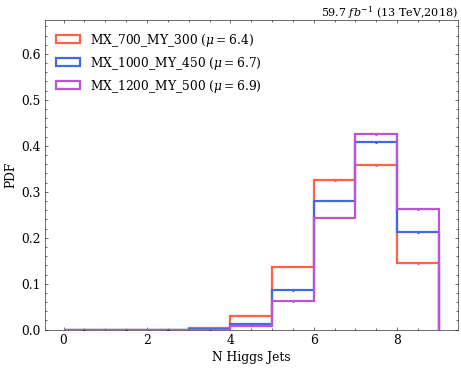

In [10]:
study.quick( 
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['nfound_all'],
    efficiency=True,
    saveas=f"{dout}/n_higgs_jets"
)

100%|██████████| 5/5 [00:00<00:00,  5.52it/s]


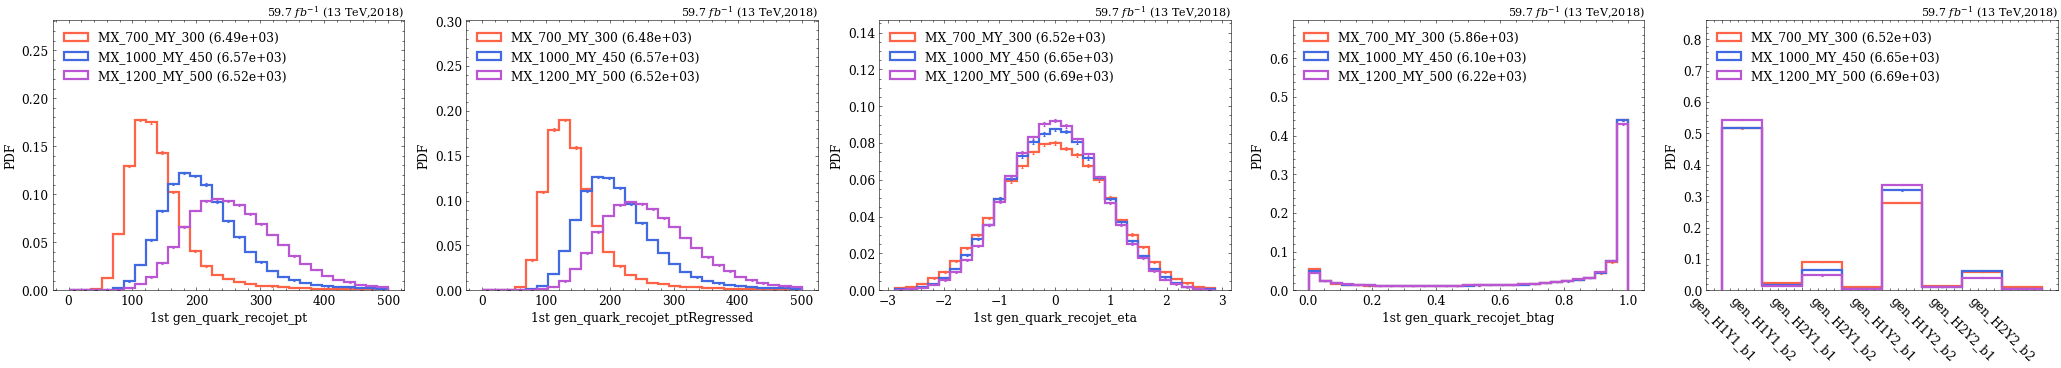

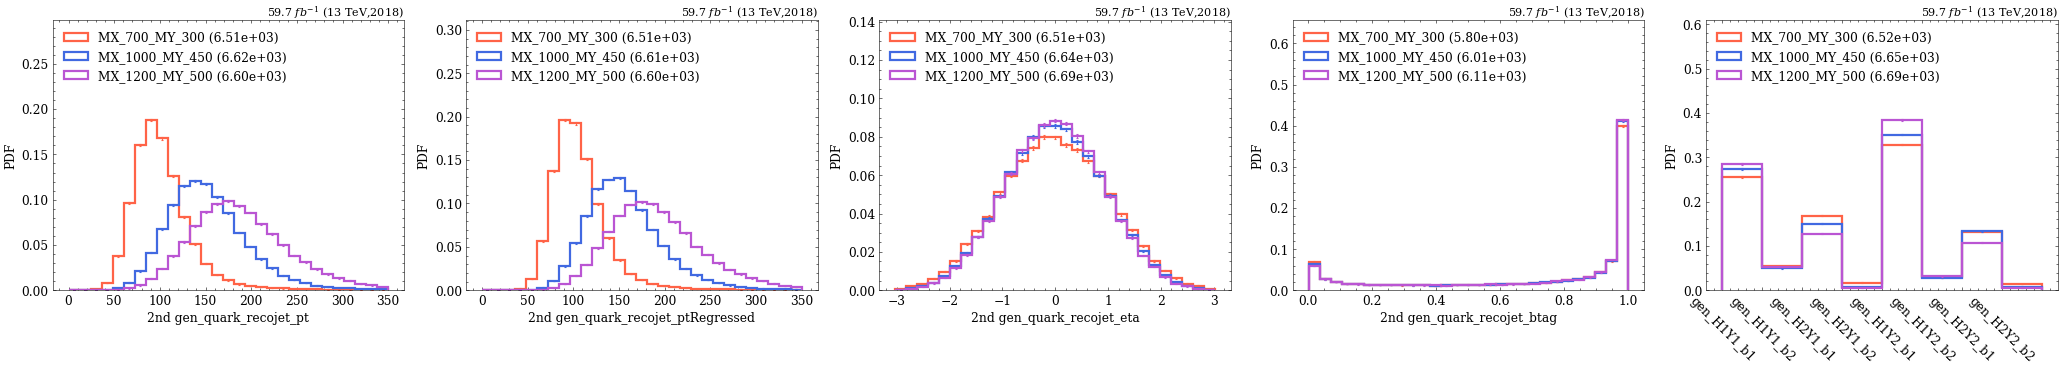

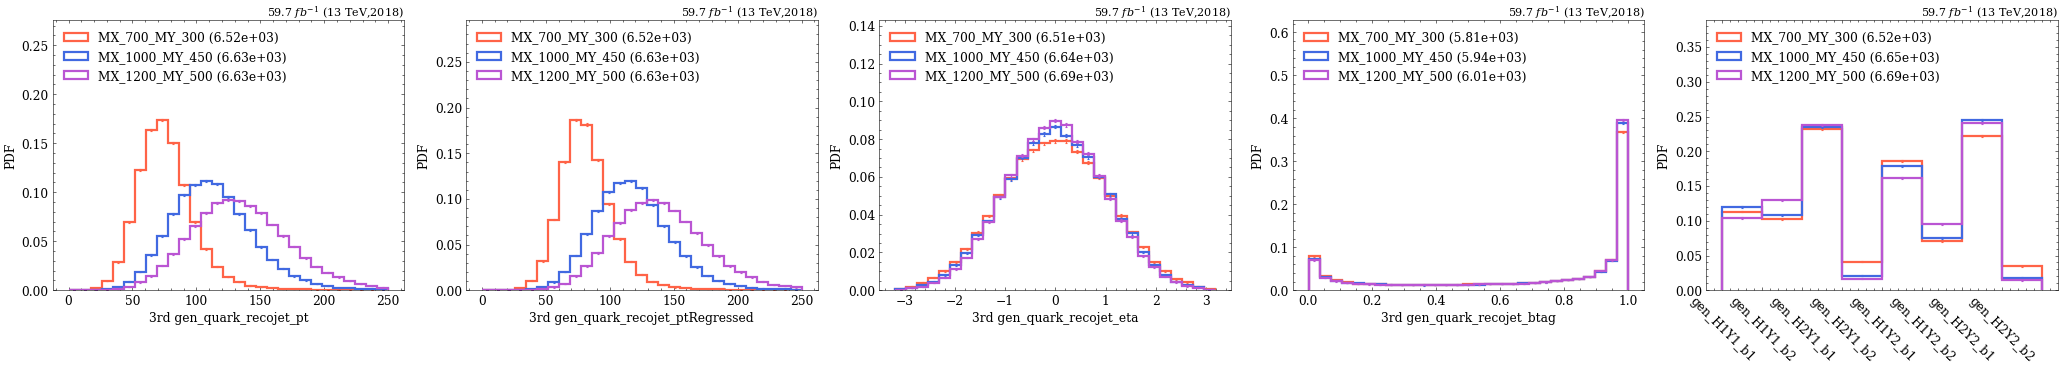

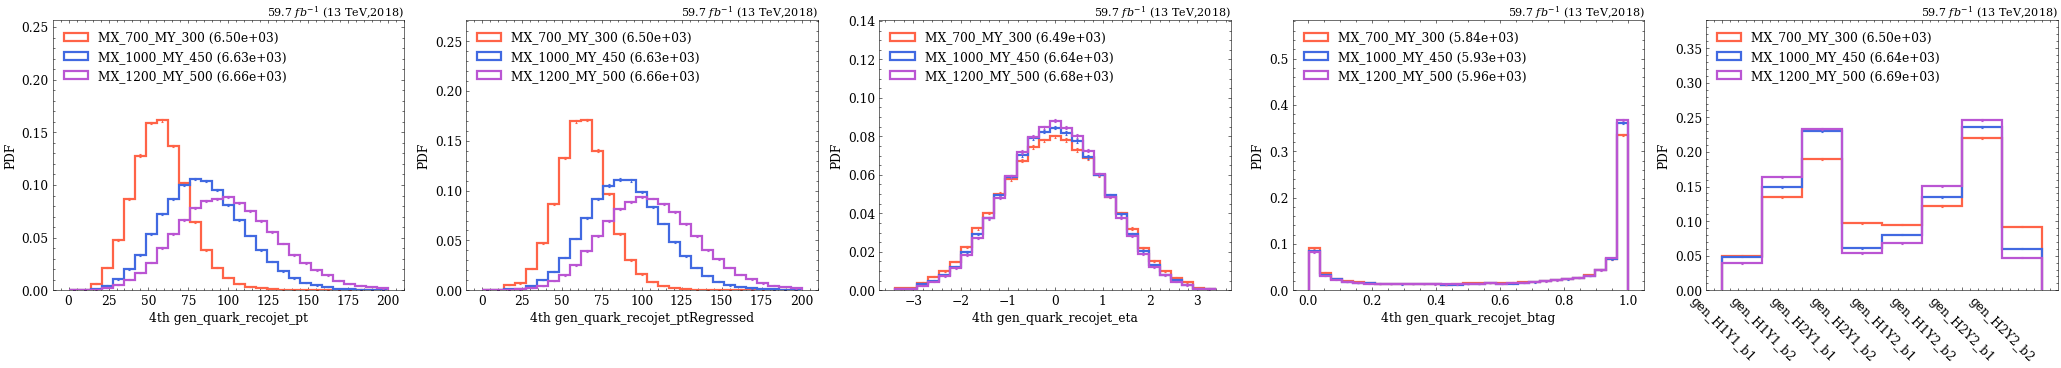

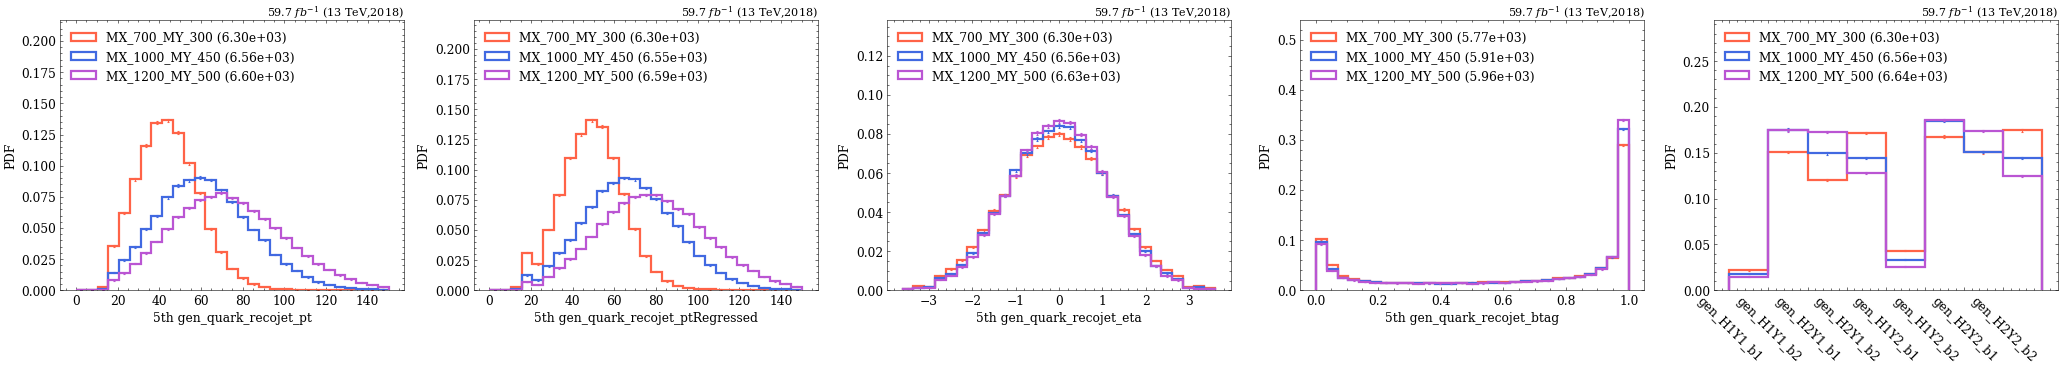

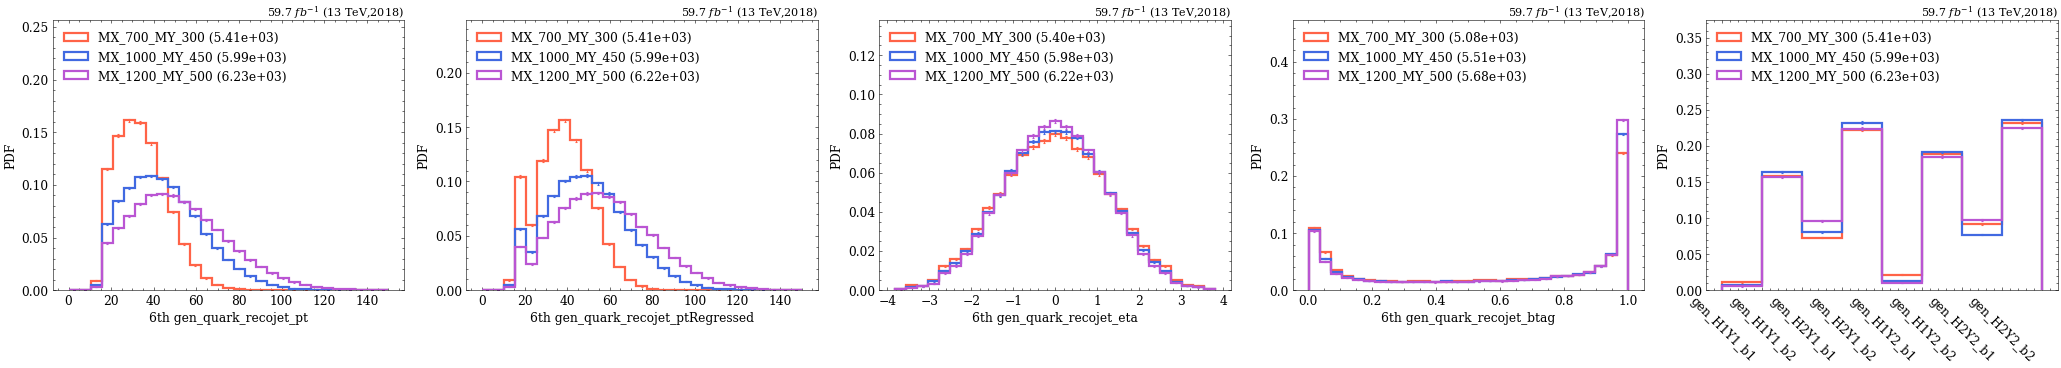

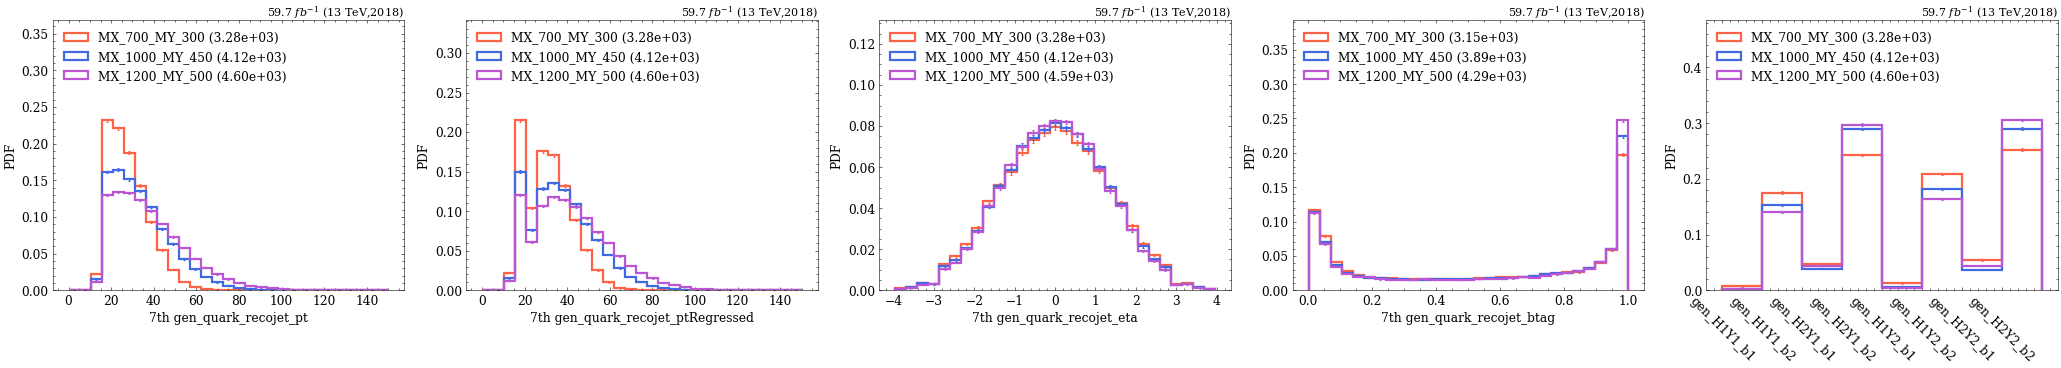

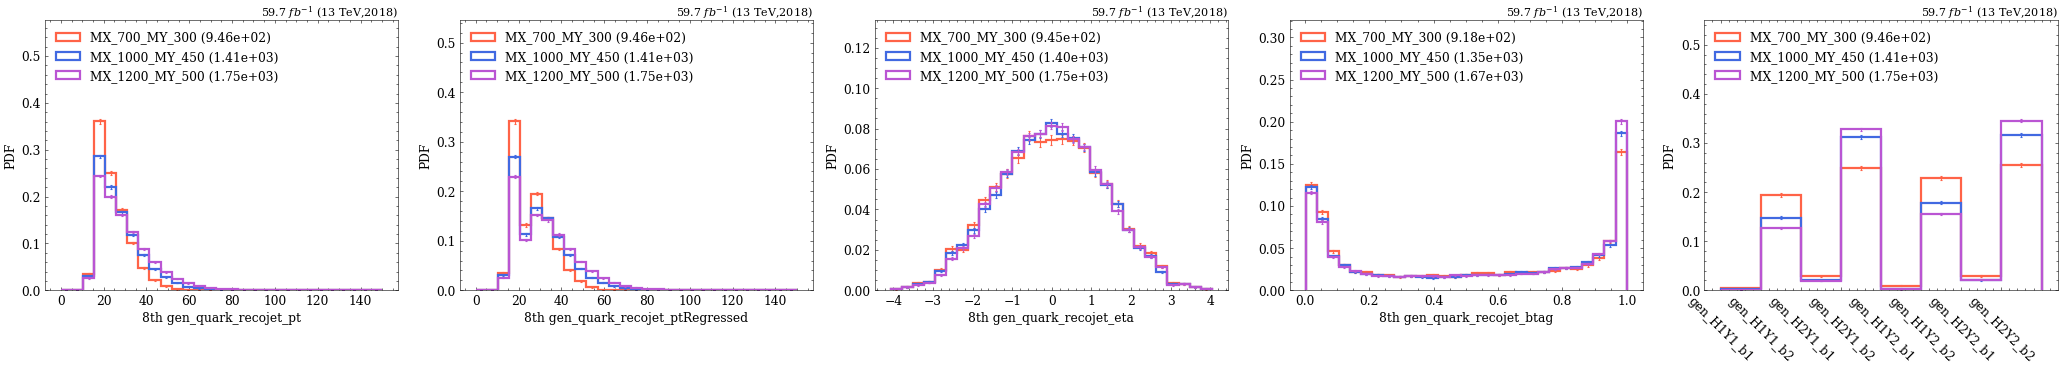

In [11]:
varlist = ['recojet_pt','recojet_ptRegressed','recojet_eta','recojet_btag','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

ptmax_ = [500,350,250,200,150,150,150,150]

for i,quark in enumerate(quarklist):
    ptmax = ptmax_[i]
    study.quick(
        signal_trees, legend=True,
        masks=lambda t : t.gen_quark_recojet_pt[:,i]>0,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)]*2,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/{ordinal(i)}_pt_reco_jet'
    )

In [12]:
trigger = 'HLT_PFHT330PT30_QuadPFJet_75_60_45_40_TriplePFBTagDeepCSV_4p5'

trigger_selection = EventFilter('trigger', **{trigger:1})

signal_trees = signal_trees.apply(trigger_selection)
signal_trees_no_pu = signal_trees_no_pu.apply(trigger_selection)

100%|██████████| 1/1 [00:00<00:00,  4.90it/s]


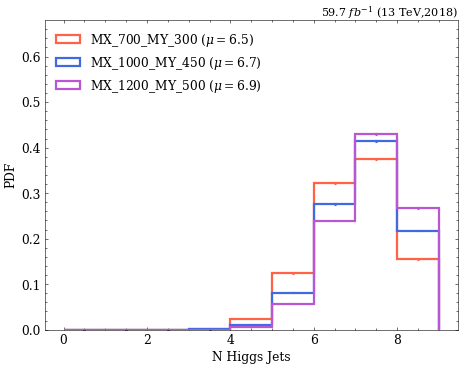

In [13]:
study.quick( 
    signal_trees, legend=True,
    h_label_stat='mean',
    varlist=['nfound_all'],
    efficiency=True,
    saveas=f"{dout}/trigger/n_higgs_jets"
)

100%|██████████| 5/5 [00:00<00:00,  8.35it/s]


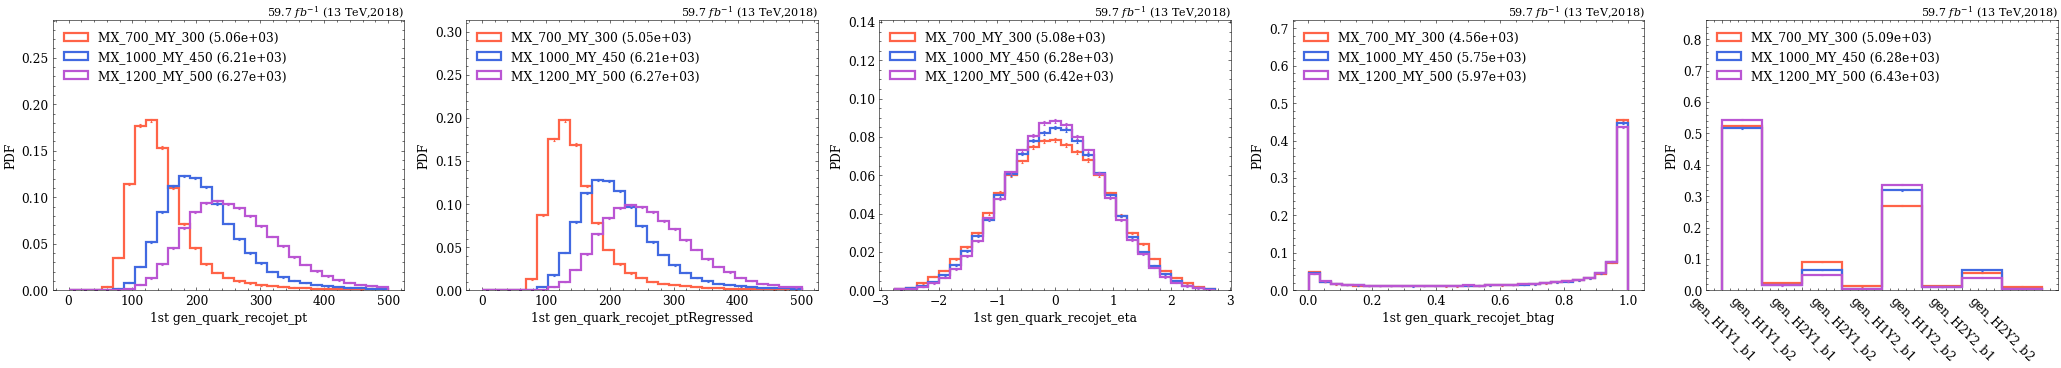

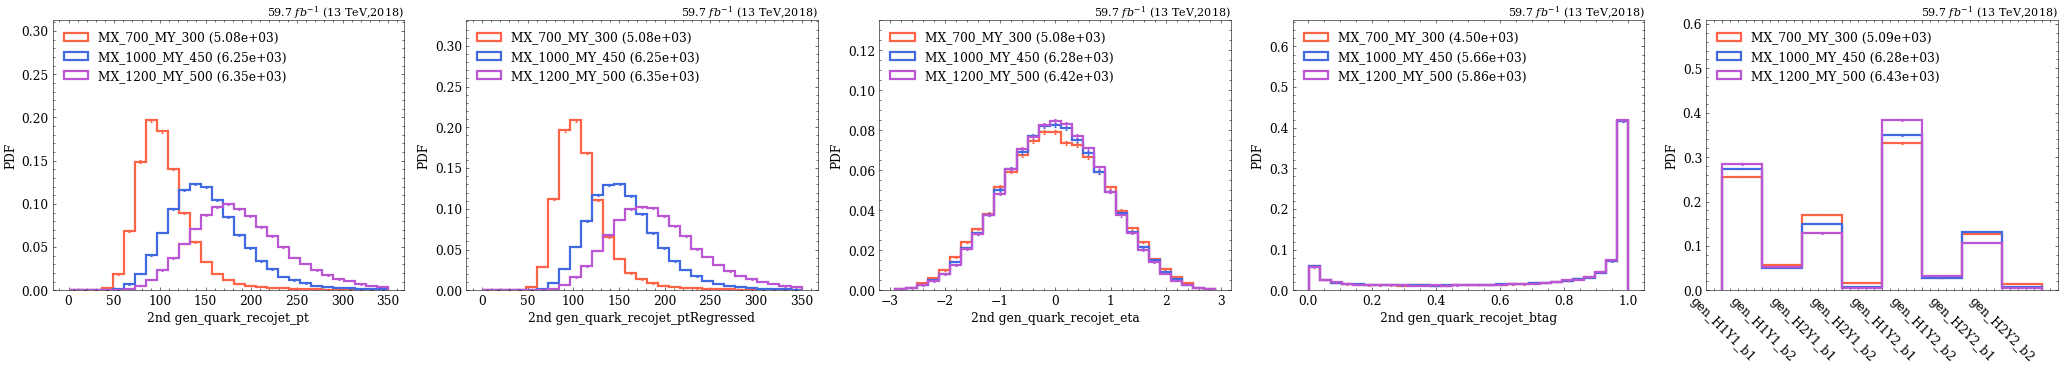

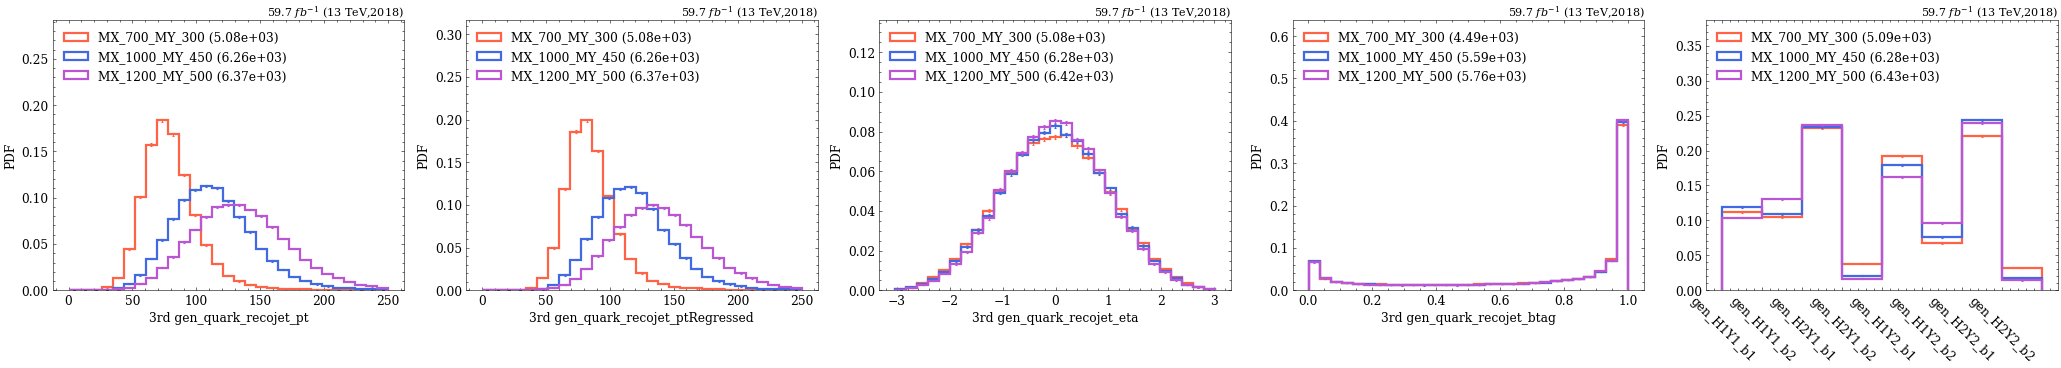

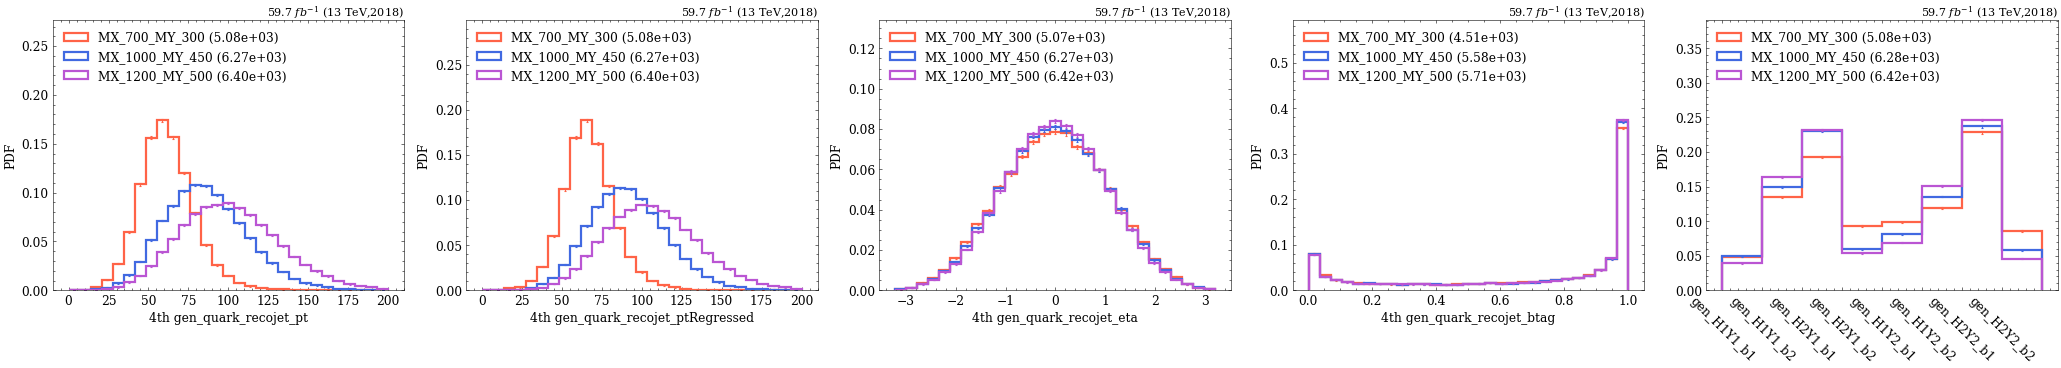

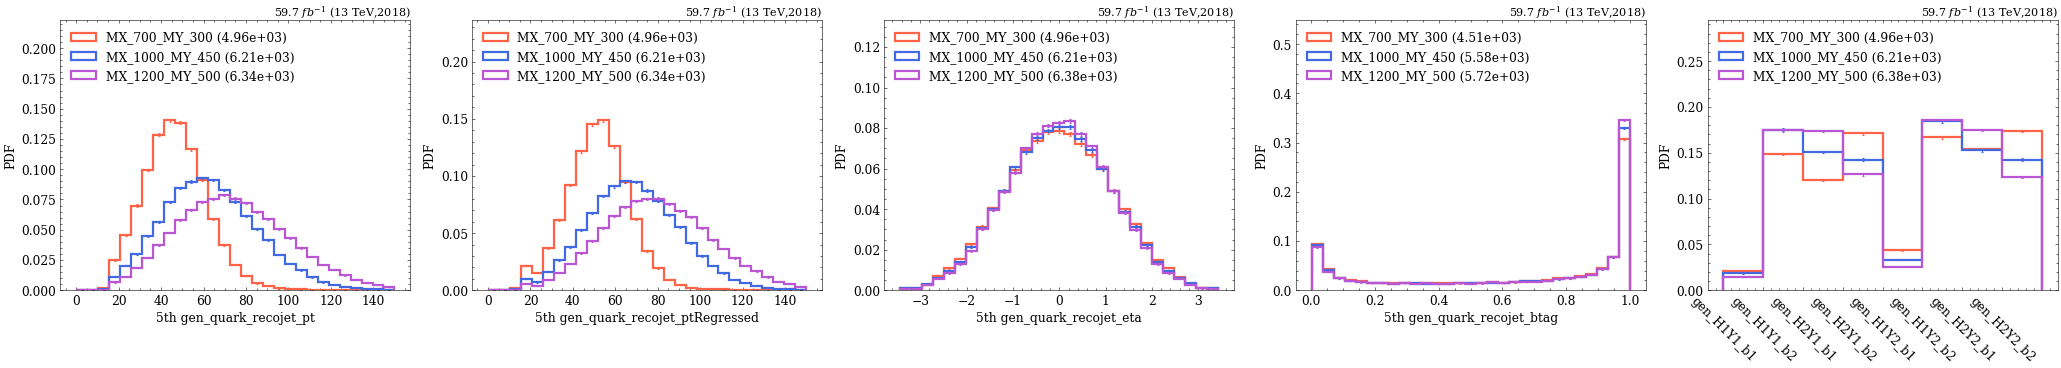

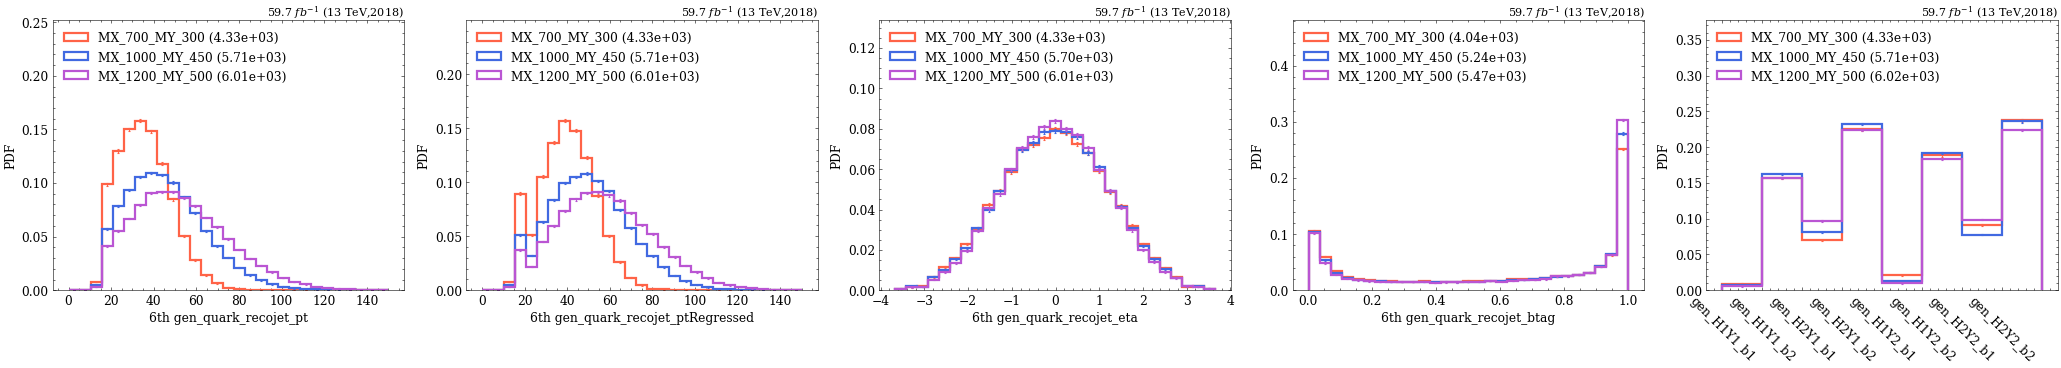

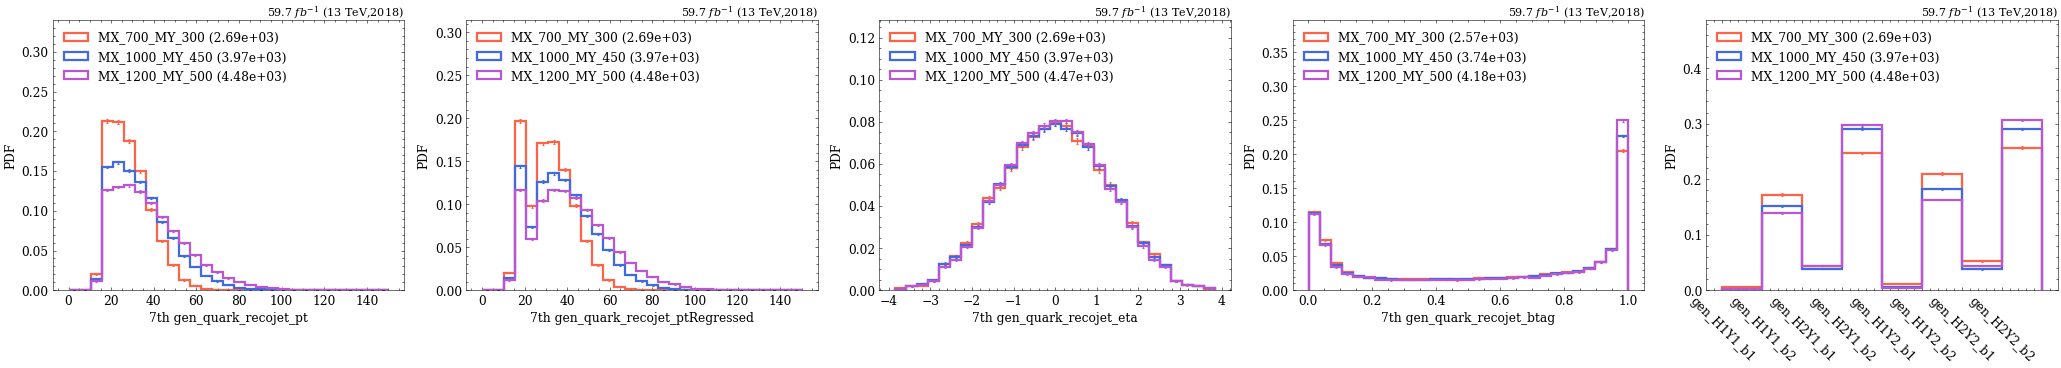

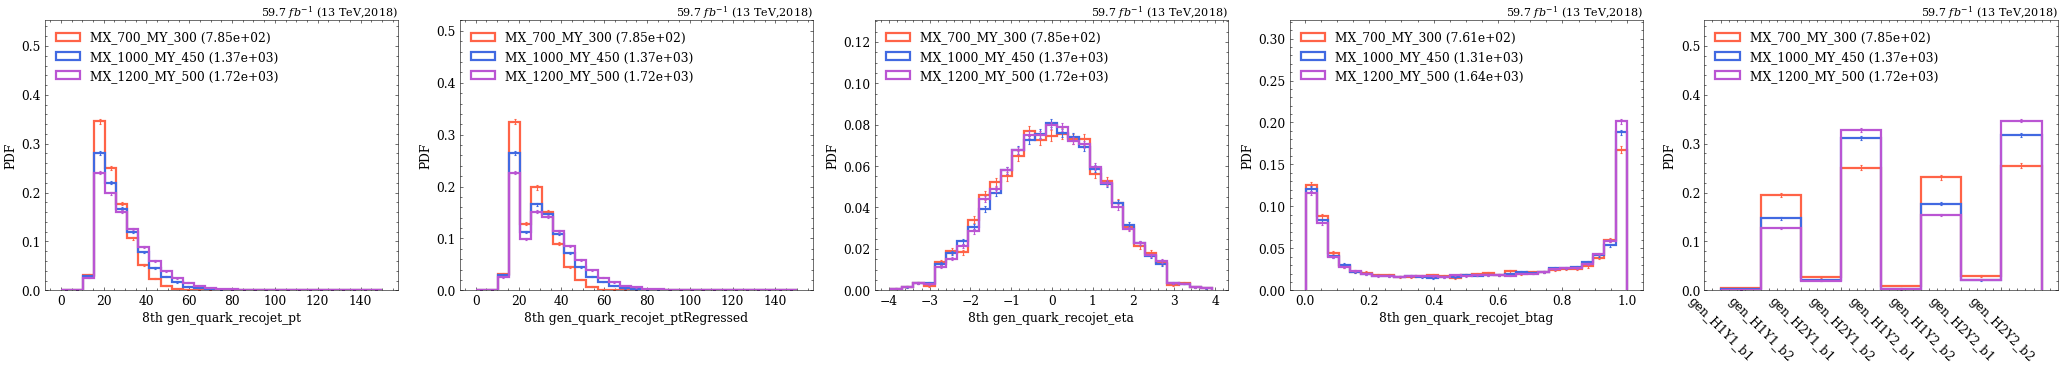

In [14]:
varlist = ['recojet_pt','recojet_ptRegressed','recojet_eta','recojet_btag','id']

varinfo.gen_quark_id = dict(xlabel=[f"gen_{quark}" for quark in eightb.quarklist], bins=np.arange(9))

ptmax_ = [500,350,250,200,150,150,150,150]

for i,quark in enumerate(quarklist):
    ptmax = ptmax_[i]
    study.quick(
        signal_trees, legend=True,
        masks=lambda t : t.gen_quark_recojet_pt[:,i]>0,
        varlist=[f'gen_quark_{var}[:,{i}]' for var in varlist],
        efficiency=True,
        binlist=[(0,ptmax,30)]*2,
        dim=(-1,len(varlist)),
        saveas=f'{dout}/trigger/{ordinal(i)}_pt_reco_jet'
    )

In [15]:
def require_recojets(t):
    recojet_pt = t.gen_quark_recojet_pt
    recojet_eta = t.gen_quark_recojet_eta
    gen_quark_recojet_pt20=(recojet_pt > 20)
    gen_quark_recojet_eta25=(np.abs(recojet_eta)<2.5)
    gen_quark_recojet_pt20eta25 = gen_quark_recojet_pt20 & gen_quark_recojet_eta25
    t.extend(
        gen_quark_recojet_pt20=gen_quark_recojet_pt20,
        gen_quark_recojet_eta25=gen_quark_recojet_eta25,
        gen_quark_recojet_pt20eta25=gen_quark_recojet_pt20eta25,
        
        n_gen_quark_recojet_pt20=ak.sum(gen_quark_recojet_pt20,axis=-1),
        n_gen_quark_recojet_eta25=ak.sum(gen_quark_recojet_eta25,axis=-1),
        n_gen_quark_recojet_pt20eta25=ak.sum(gen_quark_recojet_pt20eta25,axis=-1),
    )
signal_trees.apply(require_recojets)
signal_trees_no_pu.apply(require_recojets)


[None, None, None]

100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


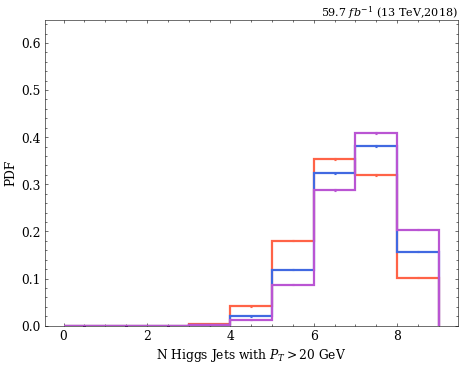

In [16]:
study.quick( 
    signal_trees,
    efficiency=True,
    varlist=['n_gen_quark_recojet_pt20'],
    xlabels=['N Higgs Jets with $P_{T}>20$ GeV'],
    saveas=f"{dout}/trigger/n_higgs_jets_pt20"
)

100%|██████████| 1/1 [00:00<00:00,  6.00it/s]


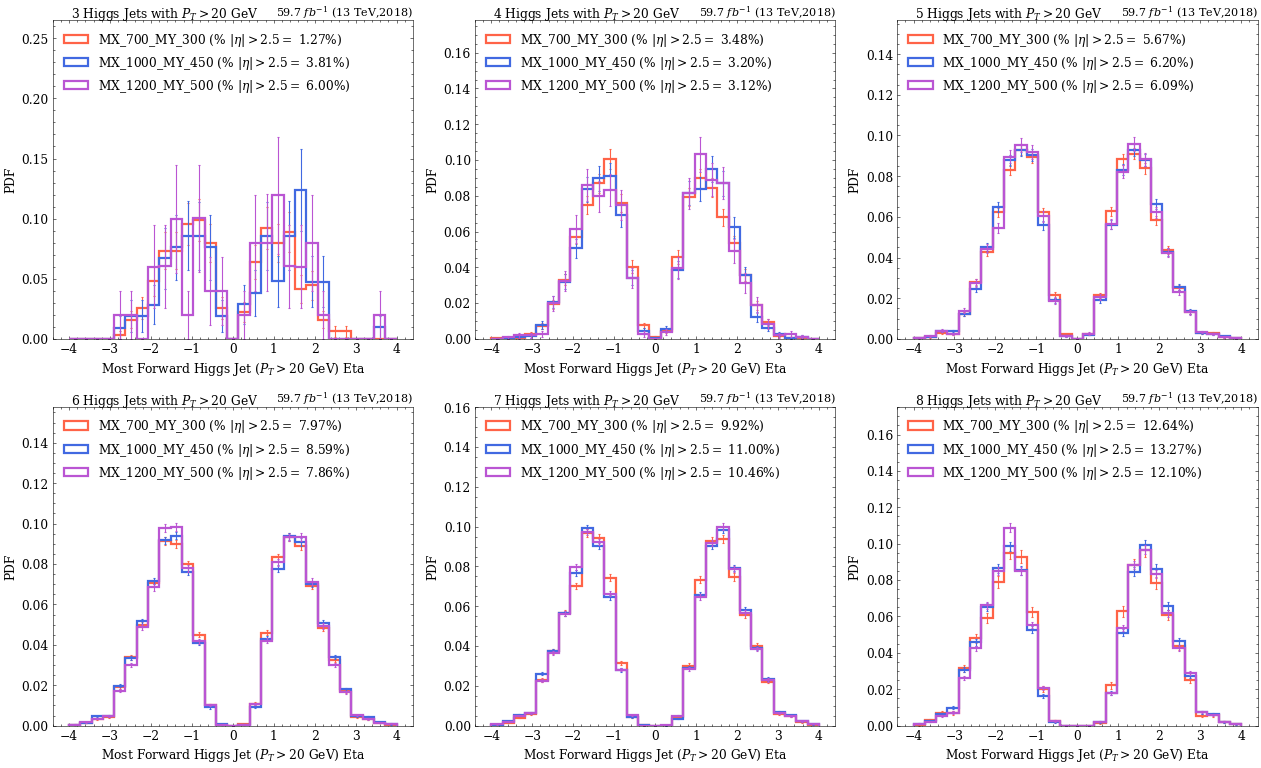

In [17]:
def most_forward_gen_quark_recojet_eta(t):
    matched_recojet_eta = t.gen_quark_recojet_eta[t.gen_quark_recojet_pt20]
    argmax = ak.argmax( np.abs(matched_recojet_eta), axis=-1, keepdims=True)
    return matched_recojet_eta[argmax]

M = np.arange(3,9)

fig, axs = study.get_figax(nvar=len(M))
for i, m in enumerate(M):
    study.quick(
        signal_trees, legend=True,
        h_label_stat=lambda h: f"% $|\eta| > 2.5 =$ {np.mean(np.abs(h.array)>2.5):0.2%}",
        masks=lambda t:t.n_gen_quark_recojet_pt20==m,
        varlist=[most_forward_gen_quark_recojet_eta],
        xlabels=['Most Forward Higgs Jet ($P_{T}>20$ GeV) Eta'],
        binlist=[(-4,4,30),(-4,4,30)],
        efficiency=True,
        text=(0.05,1.02,f'{m} Higgs Jets with $P_{{T}}>20$ GeV'),
        figax=(fig, axs.flat[i])
    )
study.save_fig(fig, saveas=f'{dout}/trigger/most_forward_higgs_jet_eta')

100%|██████████| 1/1 [00:00<00:00,  8.87it/s]


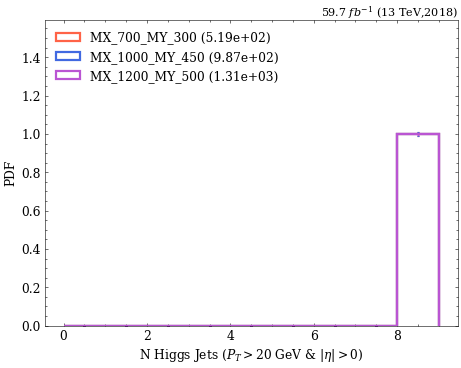

In [18]:
class n_higgs_jets(ObjTransform):
    @property
    def xlabel(self): return f'N Higgs Jets ($P_{{T}}>20$ GeV & $|\eta| > {self.eta}$)'
    def __call__(self, t):
        return ak.sum(np.abs(t.gen_quark_recojet_eta)>self.eta,axis=-1)

study.quick(
        signal_trees, legend=True,
        masks=lambda t:t.n_gen_quark_recojet_pt20==8,
        varlist=[n_higgs_jets(eta=0)],
        efficiency=True,
    )

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

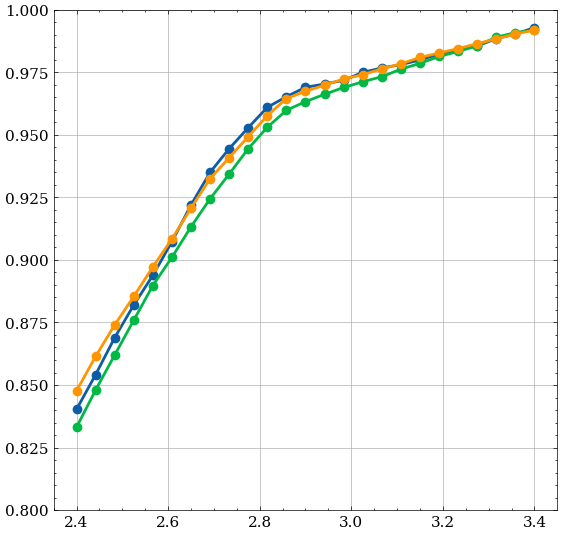

In [19]:
etas = np.linspace(2.4,3.4, 25)
def sweep_eta(t, etas=etas):
    mask = t.n_gen_quark_recojet_pt20==8
    fractions = [ak.mean(n_higgs_jets(eta=eta)(t)[mask]==0) for eta in etas]
    return np.array(fractions)

graph_arrays(etas, signal_trees.apply(sweep_eta).list, ylim=(0.8,1.0), grid=True)

In [20]:
def mask_good_recojet(t, ptcut=20, etacut=2.8):
    pt = t.gen_quark_recojet_ptRegressed
    eta = t.gen_quark_recojet_eta
    mask = (pt > ptcut) & (np.abs(eta) < etacut)
    all_pass = ak.sum(mask,axis=-1) == 8
    return mask, all_pass

In [21]:
class recojet_pt_sweep(ObjTransform):
    def __call__(self, t):
        mask, all_pass = mask_good_recojet(t, etacut=self.etacut)
        recojet_pt = t.gen_quark_recojet_pt * mask - 999*(~mask)
        recojet_pt = ak.sort(recojet_pt, axis=-1, ascending=False)

        if self.require:
            recojet_pt = recojet_pt[all_pass]

        if hasattr(self, 'mask'):
            recojet_pt = self.mask(recojet_pt)
        recojet_pt = recojet_pt[:, self.i]

        efficiency = np.array([ ak.mean( recojet_pt > pt ) for pt in self.sweep_pt ])
        return efficiency

class recojet_ptRegressed_sweep(ObjTransform):
    def __call__(self, t):
        mask, all_pass = mask_good_recojet(t, etacut=self.etacut)
        recojet_pt = t.gen_quark_recojet_ptRegressed * mask - 999*(~mask)
        recojet_pt = ak.sort(recojet_pt, axis=-1, ascending=False)[:,self.i]

        if self.require:
            recojet_pt = recojet_pt[all_pass]

        efficiency = np.array([ ak.mean( recojet_pt > pt) for pt in self.sweep_pt ])
        return efficiency

class recojet_btag_sweep(ObjTransform):
    def __call__(self, t):
        mask, all_pass = mask_good_recojet(t, etacut=self.etacut)
        recojet_btag = t.gen_quark_recojet_btag * mask - 999*(~mask)
        recojet_btag = ak.sort(recojet_btag, axis=-1, ascending=False)

        if self.require:
            recojet_btag = recojet_btag[all_pass]

        if hasattr(self, 'mask'):
            recojet_btag = self.mask(recojet_btag)
        recojet_btag = recojet_btag[:, self.i]

        efficiency = np.array([ ak.mean( recojet_btag > btag) for btag in self.sweep_btag ])
        return efficiency

class get_bound_eff(ObjTransform):
    def __call__(self, g):
        x, y  = g.x_array, g.y_array
        bound = x[y > self.eff]

        if any(bound):
            self.lower = min(self.lower, bound[-1]) if hasattr(self, 'lower') else bound[-1]
            return f'{self.eff:0.2%} < {bound[-1]:0.2f}'
        else:
            self.lower = np.nan
            return 'NaN'

In [22]:
class select_jetpt(ObjTransform):
    def __call__(self, jet_pt):
        if not any(self.ptcuts): return jet_pt
        mask = sum([ jet_pt[:,i] > pt for i, pt in enumerate(self.ptcuts) ]) == len(self.ptcuts)
        return jet_pt[mask]


In [23]:
class select_jetbtag(ObjTransform):
    def __call__(self, jet_btag):
        if not any(self.btagcuts): return jet_btag
        mask = sum([ jet_btag[:,i] > btag for i, btag in enumerate(self.btagcuts) ]) == len(self.btagcuts)
        return jet_btag[mask]

In [27]:
signal_trees.apply(lambda t : mask_good_recojet(t, etacut=2.5)[1]).apply(np.mean)

[0.08753870389483405, 0.1345370978332239, 0.17720226192779892]

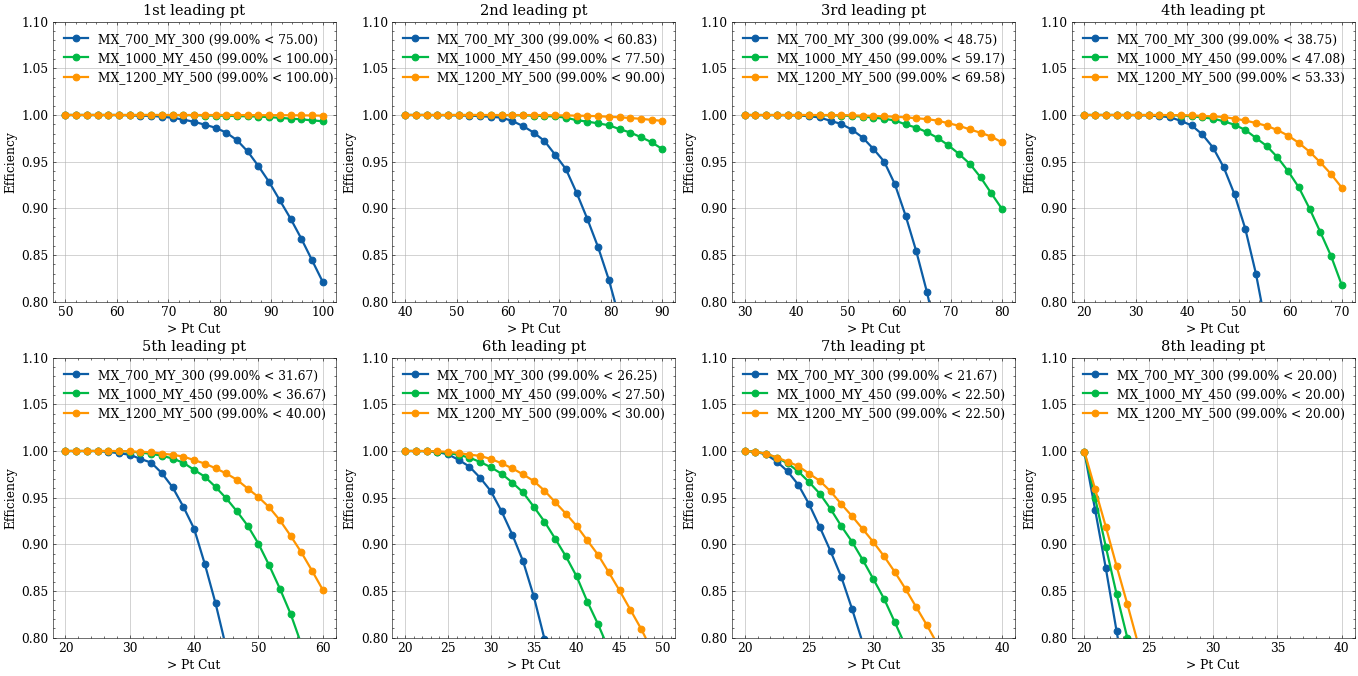

In [28]:
pt_sweeps = [
    (50,100),
    (40,90),
    (30,80),
    (20,70),
    (20,60),
    (20,50),
    (20,40),
    (20,40)
]

fig, axs = study.get_figax(nvar=len(pt_sweeps))
loose_bound = []
for i, sweep_pt in enumerate(pt_sweeps):
    sweep_pt = np.linspace(*sweep_pt, 25)

    wp_eff = get_bound_eff(eff=0.99)
    mask = select_jetpt(ptcuts=loose_bound)
    graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, etacut=2.5, require=True, i=i, mask=mask)).list, 
                ylim=(0.8,1.1), g_label=signal_trees.sample.list, 
                g_label_stat=wp_eff, xlabel='> Pt Cut', ylabel='Efficiency',
                legend=True, grid=True, title=f'{ordinal(i+1)} leading pt',
                figax=(fig,axs.flat[i]))
    loose_bound.append(wp_eff.lower)

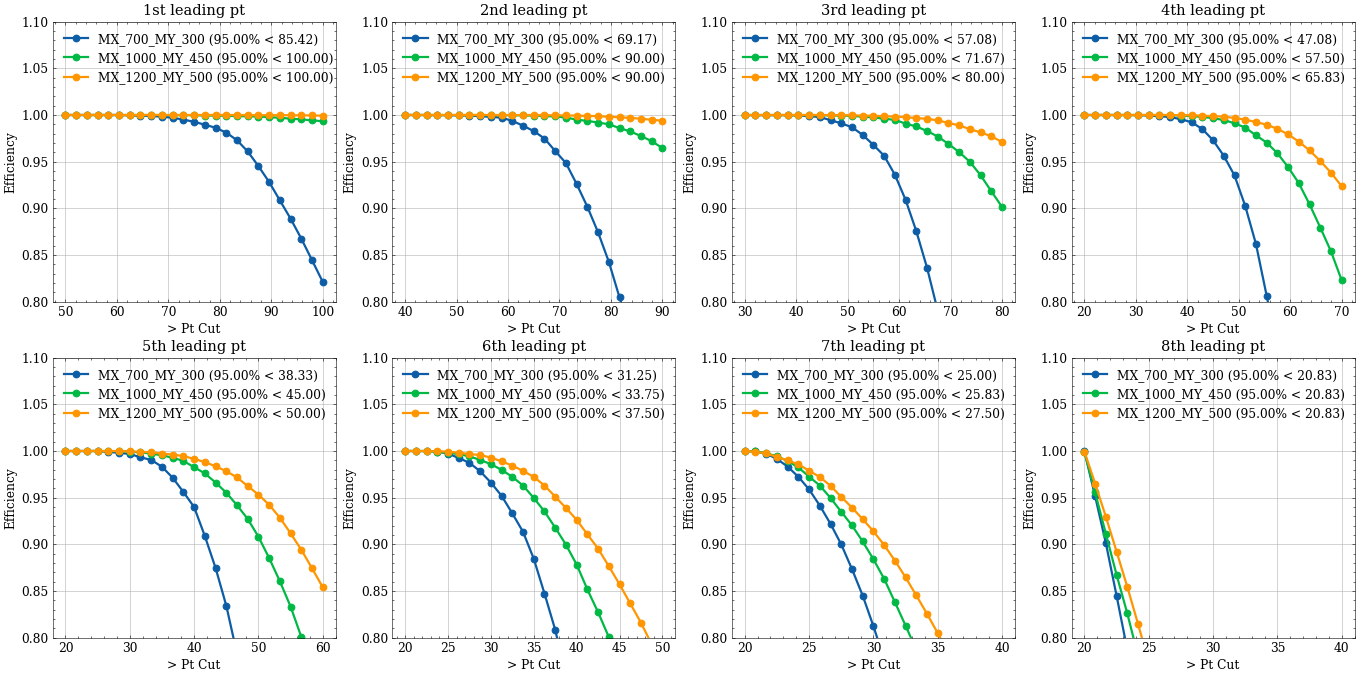

In [29]:

fig, axs = study.get_figax(nvar=len(pt_sweeps))
medium_bound = []
for i, sweep_pt in enumerate(pt_sweeps):
    sweep_pt = np.linspace(*sweep_pt, 25)

    wp_eff = get_bound_eff(eff=0.95)
    mask = select_jetpt(ptcuts=medium_bound)
    graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, etacut=2.5, require=True, i=i, mask=mask)).list, 
                ylim=(0.8,1.1), g_label=signal_trees.sample.list, 
                g_label_stat=wp_eff, xlabel='> Pt Cut', ylabel='Efficiency',
                legend=True, grid=True, title=f'{ordinal(i+1)} leading pt',
                figax=(fig,axs.flat[i]))
    medium_bound.append(wp_eff.lower)

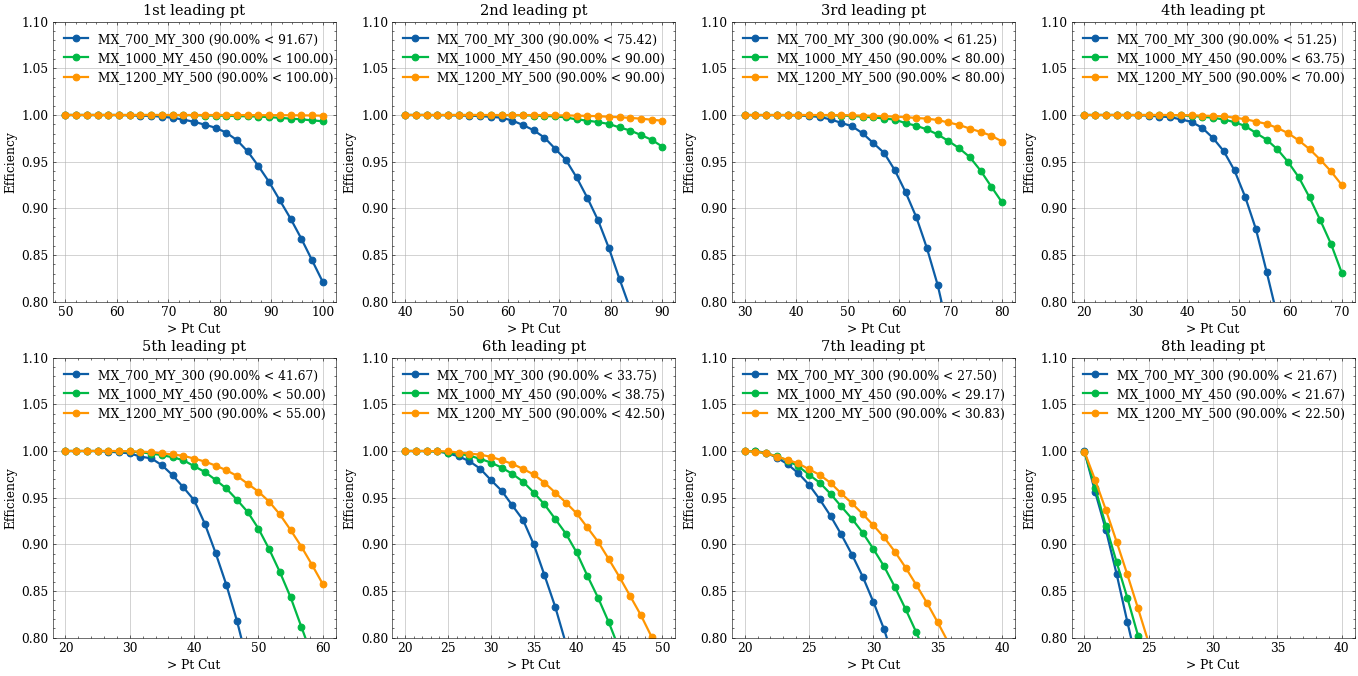

In [30]:

fig, axs = study.get_figax(nvar=len(pt_sweeps))
tight_bound = []
for i, sweep_pt in enumerate(pt_sweeps):
    sweep_pt = np.linspace(*sweep_pt, 25)

    wp_eff = get_bound_eff(eff=0.90)
    mask = select_jetpt(ptcuts=tight_bound)
    graph_arrays(sweep_pt, signal_trees.apply(recojet_pt_sweep(sweep_pt=sweep_pt, etacut=2.5, require=True, i=i, mask=mask)).list, 
                ylim=(0.8,1.1), g_label=signal_trees.sample.list, 
                g_label_stat=wp_eff, xlabel='> Pt Cut', ylabel='Efficiency',
                legend=True, grid=True, title=f'{ordinal(i+1)} leading pt',
                figax=(fig,axs.flat[i]))
    tight_bound.append(wp_eff.lower)

In [31]:
loose_bound, medium_bound, tight_bound = [ np.floor(np.array(bound)/5)*5 for bound in (loose_bound, medium_bound, tight_bound) ]

In [32]:
loose_bound[3] = 40.0

In [33]:
def build_jet_ptcut(t, ptcuts=[]):
    jet_pt = ak.sort(t.jet_pt, axis=-1, ascending=False)
    mask = jet_pt[:,0] > 0
    for i, ptcut in enumerate(ptcuts):
        mask = mask & (jet_pt[:,i]>ptcut)
    return mask

signal_trees.apply(
    # lambda t : build_jet_ptcut(t, ptcuts=loose_bound[:4])
    # lambda t : build_jet_ptcut(t, ptcuts=medium_bound[:4])
    lambda t : build_jet_ptcut(t, ptcuts=tight_bound[:4])
    # lambda t : build_jet_ptcut(t, ptcuts=[80, 65, 50, 40, 35, 30, 20, 20])
).apply(
    ak.mean
)

[0.8495165408224238, 0.976351499233968, 0.9905717173020275]

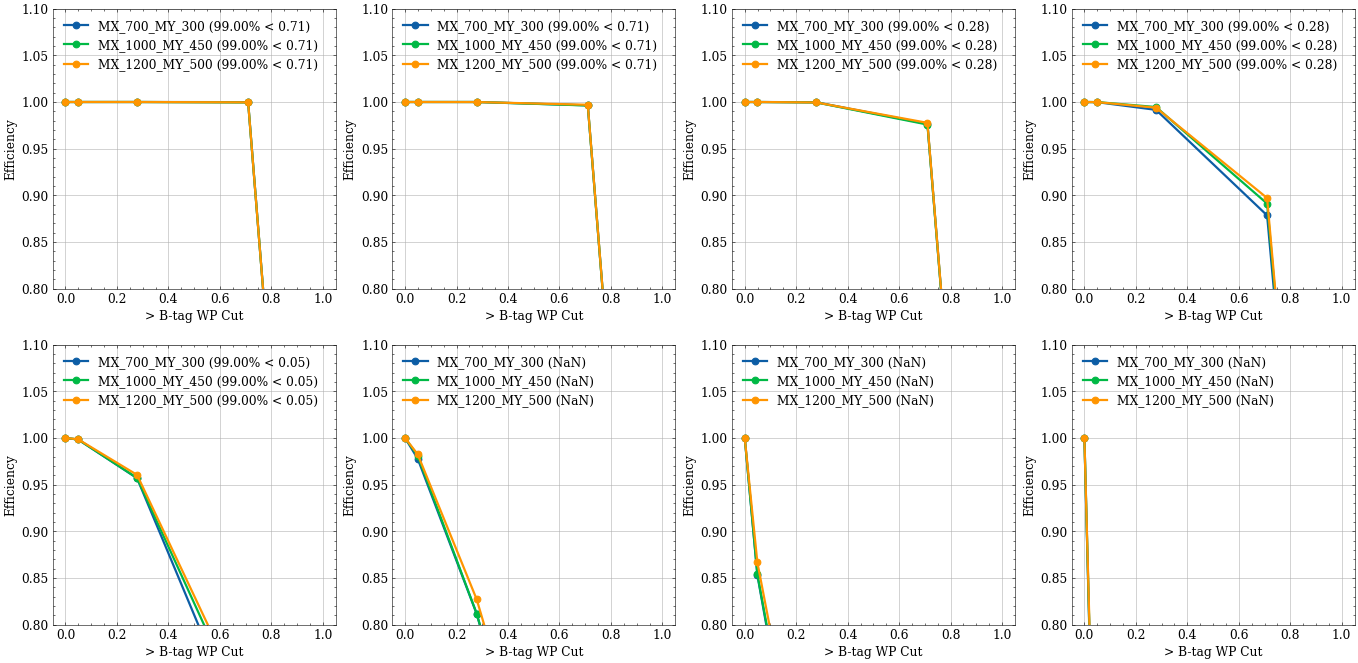

In [34]:
sweep_btag = jet_btagWP

fig, axs = study.get_figax(nvar=8)
btag_loose_bound = []
for i in range(8):
    wp_eff = get_bound_eff(eff=0.99)
    mask = select_jetbtag(btagcuts=btag_loose_bound)
    graph_arrays(
        sweep_btag, 
        signal_trees.apply(recojet_btag_sweep(sweep_btag=sweep_btag, i=i, etacut=2.5, require=True, mask=mask)).list, 
        ylim=(0.8,1.1), 
        g_label=signal_trees.sample.list, 
        g_label_stat=wp_eff, xlabel='> B-tag WP Cut',ylabel='Efficiency',
        legend=True, grid=True,
        figax=(fig,axs.flat[i]))
    btag_loose_bound.append( 0 if np.isnan(wp_eff.lower) else wp_eff.lower )


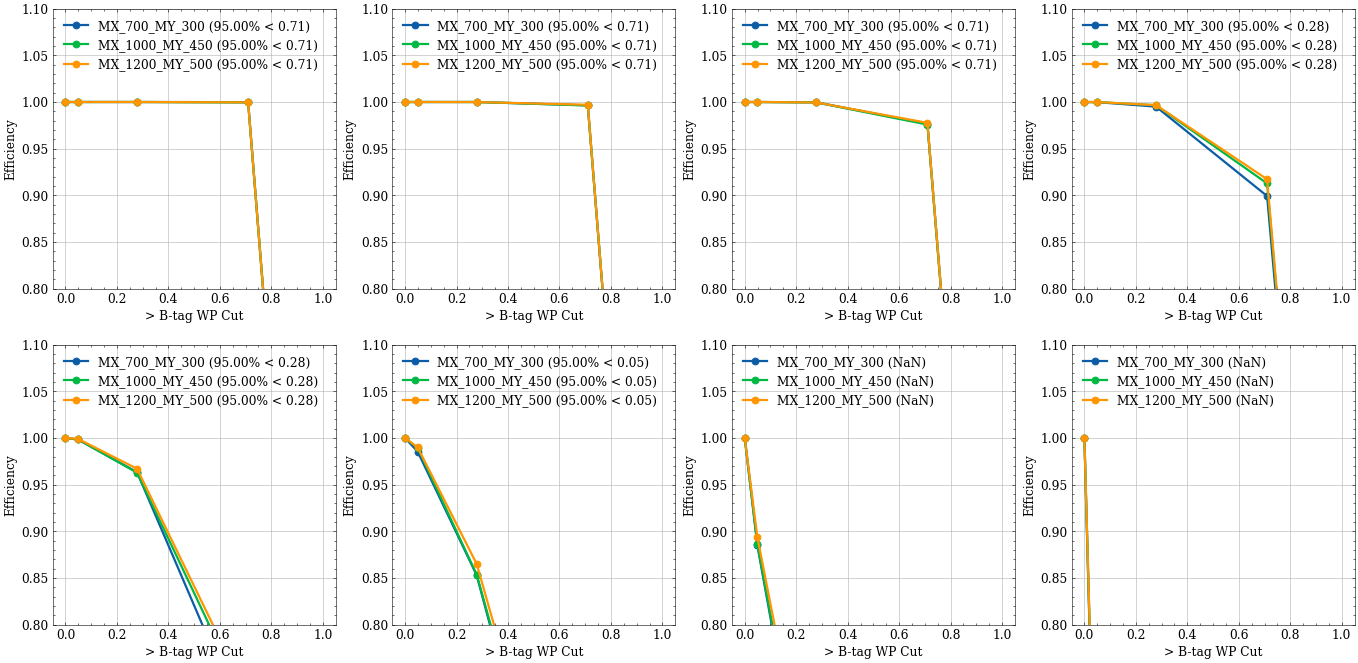

In [35]:
sweep_btag = jet_btagWP

fig, axs = study.get_figax(nvar=8)
btag_medium_bound = []
for i in range(8):
    wp_eff = get_bound_eff(eff=0.95)
    mask = select_jetbtag(btagcuts=btag_medium_bound)
    graph_arrays(
        sweep_btag, 
        signal_trees.apply(recojet_btag_sweep(sweep_btag=sweep_btag, i=i, etacut=2.5, require=True, mask=mask)).list, 
        ylim=(0.8,1.1), 
        g_label=signal_trees.sample.list, 
        g_label_stat=wp_eff, xlabel='> B-tag WP Cut',ylabel='Efficiency',
        legend=True, grid=True,
        figax=(fig,axs.flat[i]))
    btag_medium_bound.append( 0 if np.isnan(wp_eff.lower) else wp_eff.lower )

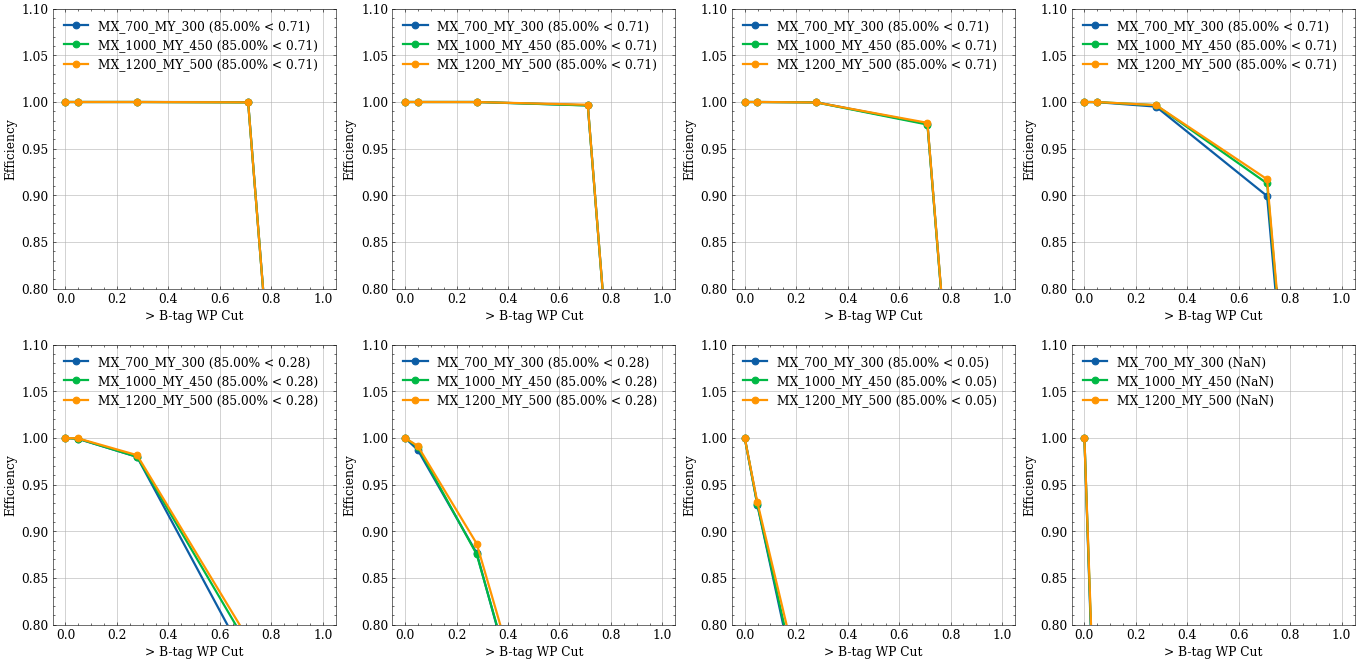

In [36]:
sweep_btag = jet_btagWP

fig, axs = study.get_figax(nvar=8)
btag_tight_bound = []
for i in range(8):
    wp_eff = get_bound_eff(eff=0.85)
    mask = select_jetbtag(btagcuts=btag_tight_bound)
    graph_arrays(
        sweep_btag, 
        signal_trees.apply(recojet_btag_sweep(sweep_btag=sweep_btag, i=i, etacut=2.5, require=True, mask=mask)).list, 
        ylim=(0.8,1.1), 
        g_label=signal_trees.sample.list, 
        g_label_stat=wp_eff, xlabel='> B-tag WP Cut',ylabel='Efficiency',
        legend=True, grid=True,
        figax=(fig,axs.flat[i]))
    btag_tight_bound.append( 0 if np.isnan(wp_eff.lower) else wp_eff.lower )

In [37]:
btag_loose_bound, btag_medium_bound, btag_tight_bound

([0.71, 0.71, 0.2783, 0.2783, 0.049, 0, 0, 0],
 [0.71, 0.71, 0.71, 0.2783, 0.2783, 0.049, 0, 0],
 [0.71, 0.71, 0.71, 0.71, 0.2783, 0.2783, 0.049, 0])

In [38]:
def build_jet_btagcut(t, btagcuts=[]):
    jet_btag = ak.sort(t.jet_btag, axis=-1, ascending=False)
    mask = jet_btag[:,0] > 0
    for i, btagcut in enumerate(btagcuts):
        if isinstance(btagcut, int):
            btagcut = jet_btagWP[btagcut]
        mask = mask & (jet_btag[:,i]> btagcut)
    return mask

signal_trees.apply(
    # lambda t : build_jet_btagcut(t, btagcuts=[0.71, 0.71, 0.2783, 0.2783, 0.049, 0, 0, 0])
    # lambda t : build_jet_btagcut(t, btagcuts=[0.71, 0.71, 0.71, 0.2783, 0.2783, 0.049, 0, 0])
    lambda t : build_jet_btagcut(t, btagcuts=[0.71, 0.71, 0.71, 0.71, 0.2783, 0.2783, 0.049, 0])
).apply(
    ak.mean
)

[0.481394969851703, 0.5349638870650033, 0.5778128964286482]

In [39]:
module = fc.eightb.preselection.t8btag_minmass
signal = ObjIter([ Tree(f, altfile='ranked_quadh_mp_{base}', report=False) for f in tqdm(module.signal_list) ])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile='ranked_quadh_mp_{base}'), Tree(module.Run2_UL18.TTJets, altfile='ranked_quadh_mp_{base}')])

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


In [40]:
(signal + bkg).apply(lambda t:build_collection(t, 'H\dY\d_b\d', 'jet', ordered='pt'))

[None, None, None, None, None]

In [41]:
jetpt_filters = { wp : eightb.selected_jet_pt(wp) for wp in ('loose','medium','tight')}
jetbtag_filters = { wp : eightb.selected_jet_btagwp(wp) for wp in ('loose','medium','tight')}

In [47]:
def get_eff(t):
    if not isinstance(t, ObjIter): t= ObjIter([t])

    print(t.sample)
    scale = t.scale.cat
    total = ak.sum(scale)
    for wp, f in jetpt_filters.items():
        mask = t.apply(f.filters[0]).cat
        yields = ak.sum(scale[mask])
        print('pt', wp, f"{yields/total:0.2}")

    
    for wp, f in jetbtag_filters.items():
        mask = t.apply(f.filters[0]).cat
        yields = ak.sum(scale[mask])
        print('btag', wp, f"{yields/total:0.2}")

signal.apply(get_eff)
get_eff(bkg)

['MX_700_MY_300']
pt loose 0.96
pt medium 0.77
pt tight 0.67
btag loose 0.93
btag medium 0.72
btag tight 0.37
['MX_1000_MY_450']
pt loose 0.99
pt medium 0.89
pt tight 0.86
btag loose 0.95
btag medium 0.77
btag tight 0.44
['MX_1200_MY_500']
pt loose 0.99
pt medium 0.92
pt tight 0.91
btag loose 0.96
btag medium 0.81
btag tight 0.48
['QCD', 'TTJets']
pt loose 0.93
pt medium 0.69
pt tight 0.59
btag loose 0.056
btag medium 0.0063
btag tight 0.00038


100%|██████████| 1/1 [00:00<00:00,  1.32it/s]


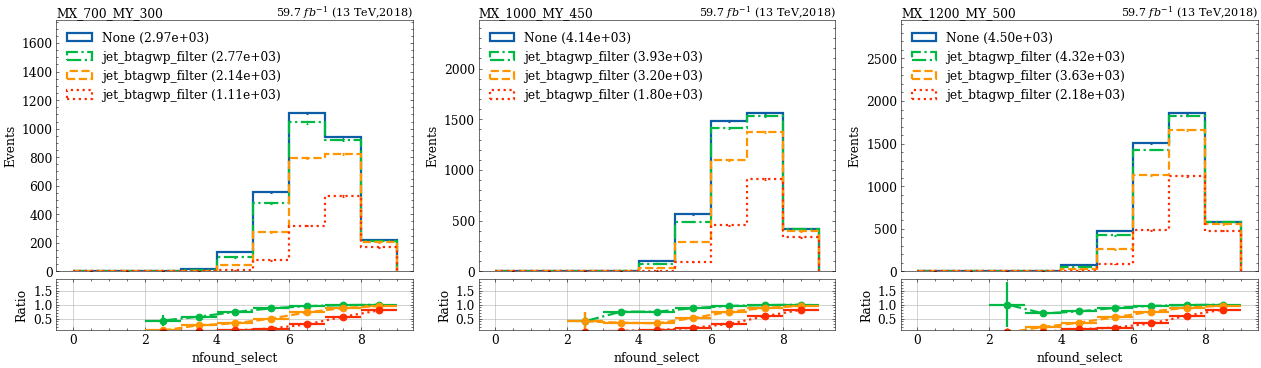

In [146]:
study.compare_masks( 
    signal, legend=True,
    h_color=None,
    masks=[None]+[ filter.filters[0] for filter in jetbtag_filters.values() ],
    varlist=['nfound_select'],
    ratio=True, r_inv=True,
)

100%|██████████| 1/1 [00:00<00:00,  1.22it/s]


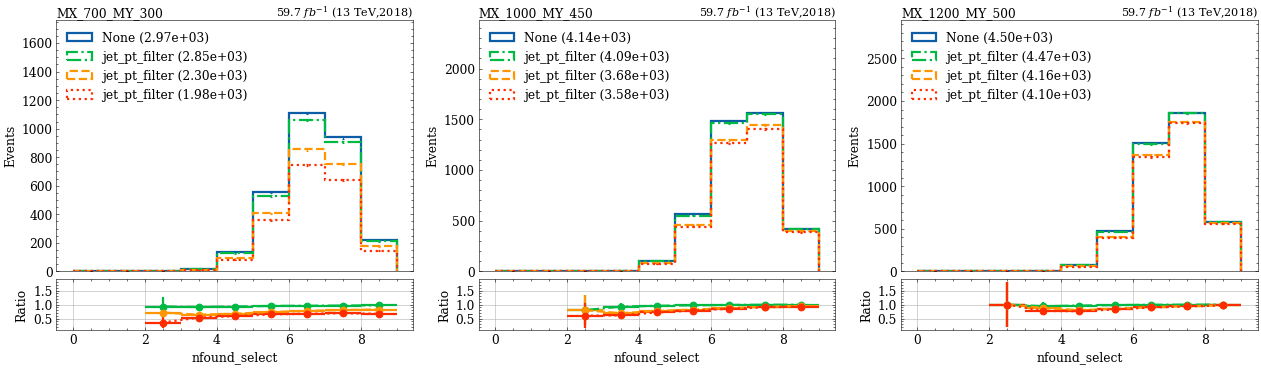

In [142]:
study.compare_masks( 
    signal, legend=True,
    h_color=None,
    masks=[None]+[ filter.filters[0] for filter in jetpt_filters.values() ],
    varlist=['nfound_select'],
    ratio=True, r_inv=True,
)

100%|██████████| 2/2 [00:07<00:00,  3.83s/it]


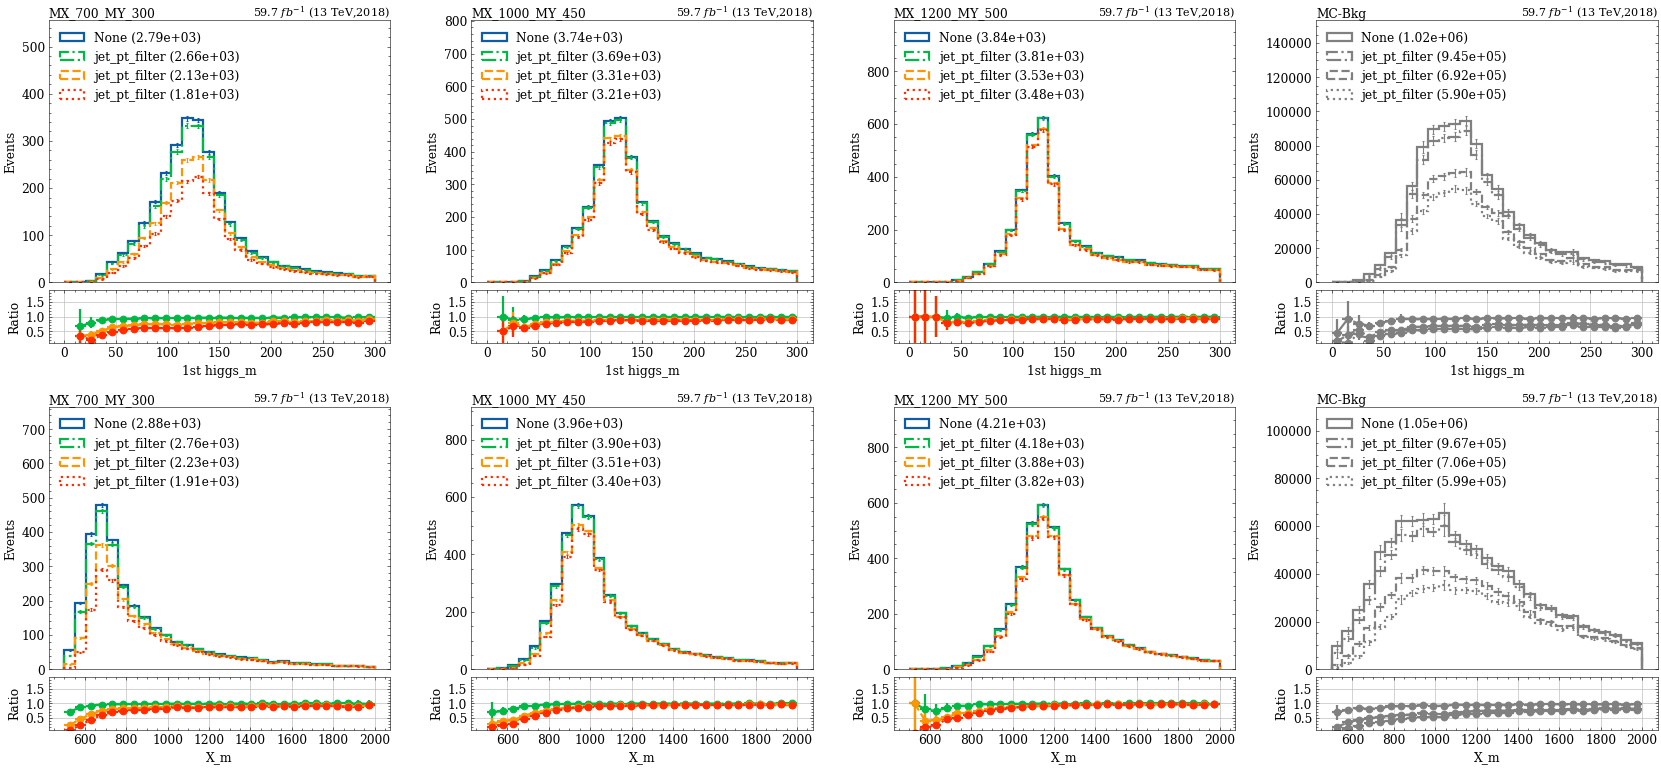

In [148]:
study.compare_masks( 
    signal, bkg, legend=True,
    h_color=None,
    masks=[None]+[ filter.filters[0] for filter in jetpt_filters.values() ],
    varlist=['higgs_m[:,0]','X_m'],
    ratio=True, r_inv=True,
)

100%|██████████| 2/2 [00:07<00:00,  3.54s/it]


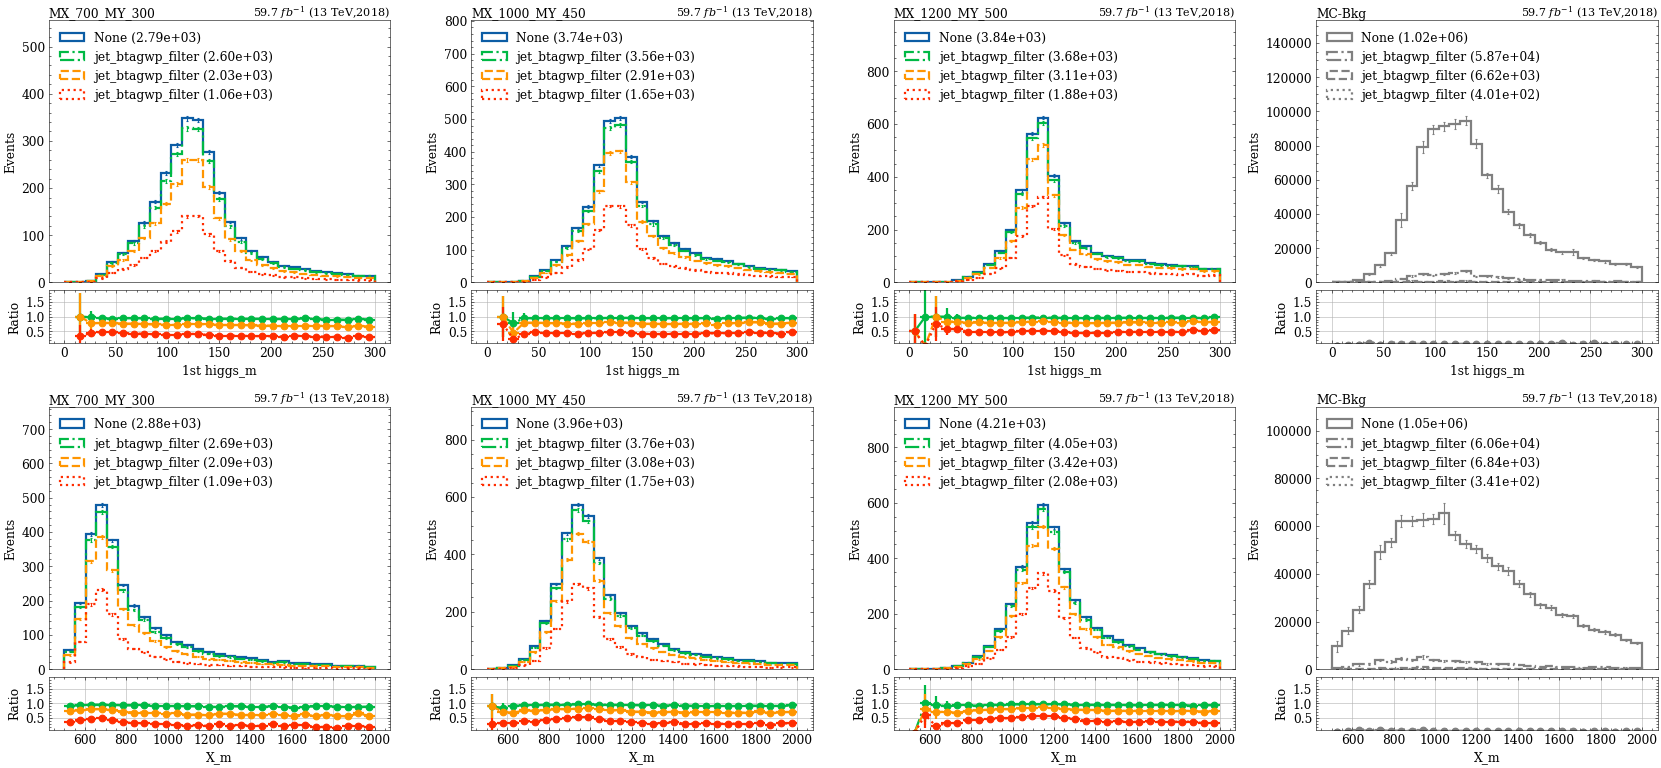

In [149]:
study.compare_masks( 
    signal, bkg, legend=True,
    h_color=None,
    masks=[None]+[ filter.filters[0] for filter in jetbtag_filters.values() ],
    varlist=['higgs_m[:,0]','X_m'],
    ratio=True, r_inv=True,
)

In [161]:
signal = signal.apply(select_jet_ptcut)
bkg = bkg.apply(select_jet_ptcut)


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


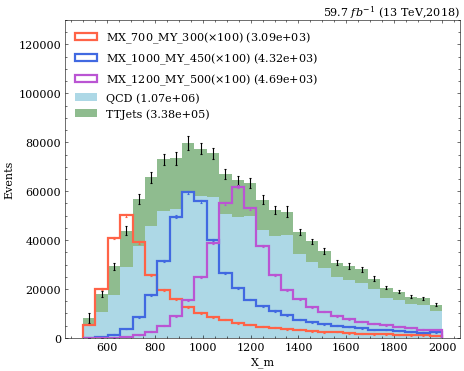

In [162]:
study.quick( 
    signal+bkg, legend=True,
    plot_scale=[100]*len(signal),
    varlist=['X_m']
)

In [163]:
signal = signal.apply(select_jet_btagmulti)
bkg = bkg.apply(select_jet_btagmulti)


100%|██████████| 1/1 [00:01<00:00,  1.16s/it]


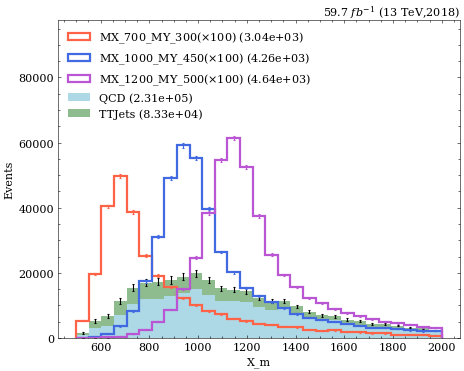

In [164]:
study.quick( 
    signal+bkg, legend=True,
    plot_scale=[100]*len(signal),
    varlist=['X_m']
)